<h3 style='font-size: 20px; color: Crimson; font-family: Candara; font-weight: 600'>Import Required Libraries</h3>

In [2]:
# Statistical analysis libraries
from statsmodels.stats.multicomp import pairwise_tukeyhsd  
from statsmodels.stats.anova import anova_lm  
from statsmodels.formula.api import ols
from statsmodels.formula.api import ols as smf_ols 
import statsmodels.formula.api as smf 
import statsmodels.api as sm  

# Data transformation and analysis
from sklearn.preprocessing import PowerTransformer 
from scipy.stats import shapiro, levene, skew, kurtosis 
import scipy.stats as stats  
import researchpy as rp 

# Data manipulation and visualization
import matplotlib.pyplot as plt  
import seaborn as sns  
import pandas as pd  
import numpy as np 
import math  
import re 
import string

# Miscellaneous
import warnings  
warnings.simplefilter("ignore")  
pd.set_option('display.max_columns', 8) 
pd.set_option('display.float_format', lambda x: '%.2f' % x)  # Control floating-point display format

print("Libraries Loaded Successfully")

Libraries Loaded Successfully


<h3 style='font-size: 20px; color: crimson; font-family: Candara; font-weight: 600'>Import and Preprocessing Dataset</h3>

In [45]:
df = pd.read_excel('Datasets/Abelson makabala-v1.xlsx')
df.head()

,Weed species,Botanical name,Treatment,Week,Application status,Weed population
0,Black jack,Bidens pilosa,Herbecide,0,Before Application,2666.667
1,Coach grass,Cyperus rotundus,Herbecide,0,Before Application,1666.667
2,Coach grass,Cyperus rotundus,Herbecide,0,Before Application,9000.000
3,Mexican clover,Richard gandfolia,Herbecide,0,Before Application,11000.000
4,Star grass,Cynodon dactylon,Herbecide,0,Before Application,5000.000


<h4 style='font-size: 18px; color: blue; font-family: Candara; font-weight: 600'>1.1: Dataset Informations/ Overview</h4>

In [3]:
df.shape

(75, 6)

In [4]:
df.columns

Index(['Weed species', 'Botanical name', 'Treatment', 'Week',
       'Application status', 'Weed population'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Weed species        75 non-null     object 
 1   Botanical name      75 non-null     object 
 2   Treatment           75 non-null     object 
 3   Week                75 non-null     int64  
 4   Application status  75 non-null     object 
 5   Weed population     75 non-null     float64
dtypes: float64(1), int64(1), object(4)
memory usage: 3.6+ KB


<h4 style='font-size: 18px; color: blue; font-family: Candara; font-weight: 600'>1.1: Drop Irrelevant Columns</h4>

In [6]:
df = df.drop(columns=['Weed species'])
df.columns

Index(['Botanical name', 'Treatment', 'Week', 'Application status',
       'Weed population'],
      dtype='object')

<h4 style='font-size: 18px; color: blue; font-family: Candara; font-weight: 600'>1.3: Columns Summary</h4>

In [7]:
def column_summary(df):
    summary_data = []
    
    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()
        
        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df


summary_df = column_summary(df)
display(summary_df)

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,Botanical name,object,0,75,7,"{'Bidens pilosa': 12, 'Richard gandfolia': 12,..."
1,Treatment,object,0,75,3,"{'Herbecide': 25, 'Manual Weeding': 25, 'Mulc..."
2,Week,int64,0,75,4,"{0: 21, 1: 18, 2: 18, 3: 18}"
3,Application status,object,0,75,3,"{'Other': 50, 'Before Application': 19, 'After..."
4,Weed population,float64,0,75,41,"{0.0: 9, 4000.0: 7, 3000.0: 6, 2666.6666666666..."


<h4 style='font-size: 18px; color: Blue; font-family: Candara; font-weight: 600'>1.4: Handling Missing Values</h4>

In [8]:
def Missig_values_info(df):   
    isna_df = df.isna().sum().reset_index(name='Missing Values Counts')
    isna_df['Proportions (%)'] = isna_df['Missing Values Counts']/len(df)*100
    return isna_df
    
isna_df = Missig_values_info(df)
isna_df

,index,Missing Values Counts,Proportions (%)
0,Botanical name,0,0.00
1,Treatment,0,0.00
2,Week,0,0.00
3,Application status,0,0.00
4,Weed population,0,0.00


<h4 style='font-size: 18px; color: Blue; font-family: Candara; font-weight: 600'>1.5: Handling Duplicates Values</h4>

In [9]:
df.duplicated().sum()

np.int64(0)

<h4 style='font-size:18px; color: Blue; font-family: Candara; font-weight: 600'>1.4: Renaming Columns</h4>

When working with data, especially in statistical tests like ANOVA, column names with special characters or spaces can cause errors. To avoid this, we can clean the column names by converting them to lowercase, replacing any special characters (such as punctuation) with underscores, and ensuring there are no spaces. This makes the column names consistent and compatible with most analysis functions, preventing errors during data processing. The renaming process is automatic, making it easy to handle datasets with potentially problematic column names.

In [10]:
import re

def rename(text):
    text = text.lower()                      
    text = re.sub(r'[^\w\s]', '_', text)
    text = re.sub(r' ', '_', text)
    return text

data = df.copy()
data.columns = df.columns.to_series().apply(rename)
data.head()

,botanical_name,treatment,week,application_status,weed_population
0,Bidens pilosa,Herbecide,0,Before Application,2666.67
1,Cyperus rotundus,Herbecide,0,Before Application,1666.67
2,Cyperus rotundus,Herbecide,0,Before Application,9000.00
3,Richard gandfolia,Herbecide,0,Before Application,11000.00
4,Cynodon dactylon,Herbecide,0,Before Application,5000.00


<h1 style='font-size: 20px; color: green; font-family: Candara; font-weight: 600'>2.0: Detection and Handling Outliers</h1>

An **outlier** is a data point that significantly deviates from the overall pattern of a dataset. It appears as an unusually high or low value compared to the majority of observations. Outliers can result from measurement errors, data entry mistakes, or natural variations within the data. Their presence can distort statistical analysis, affecting measures such as the mean, standard deviation, and regression models.  

To ensure data integrity and accurate insights, we need to **detect and handle outliers** appropriately. Detection methods include statistical approaches like the **Z-score**, **interquartile range (IQR)**, and **visual tools such as box plots and scatter plots**. Once identified, handling outliers involves assessing their impact and determining whether to retain, transform, or remove them based on the context and objective of the analysis.

<h4 style='font-size: 18px; color: blue; font-family: Candara; font-weight: 600'>2.1: Visualize Outliers Using Boxplots</h4>

Boxplots are a great way to visualize the distribution of data and identify outliers. Outliers are typically represented as individual points outside the "whiskers" of the boxplot.

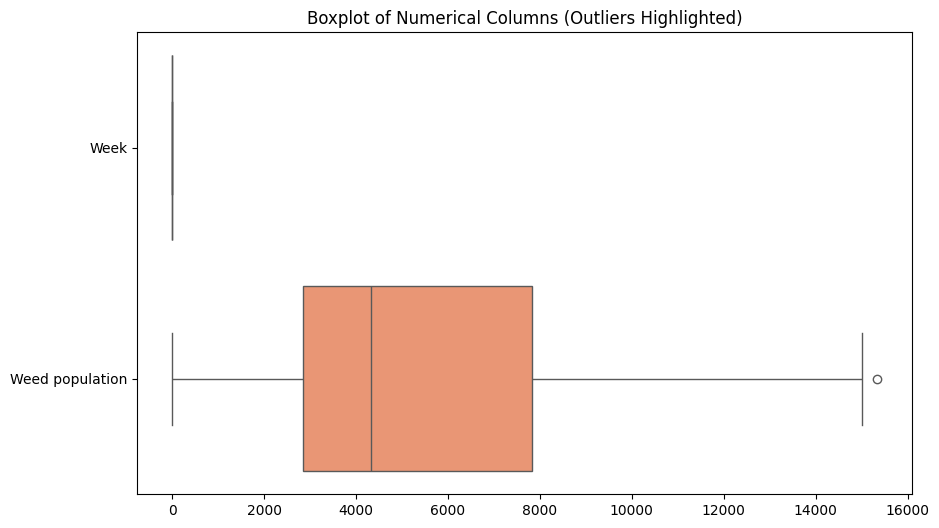

In [11]:
def visualize_outliers_boxplot(df):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, orient="h", palette="Set2")
    plt.title("Boxplot of Numerical Columns (Outliers Highlighted)")
    plt.show()

visualize_outliers_boxplot(df)

<h4 style='font-size: 18px; color: blue; font-family: Candara; font-weight: 600'>2.2: Outliers Proportions in Dataset Using(IQR)</h4>

In [12]:
def detect_outliers_iqr(df):
    outlier_counts = {}
    outlier_percentages = {}
    
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_counts[col] = len(outliers)
        outlier_percentages[col] = (len(outliers) / len(df)) * 100
    
    return pd.DataFrame({'Outlier Count': outlier_counts, 'Outlier Percentage (%)': outlier_percentages})
outlier_df = detect_outliers_iqr(df)
outlier_df

,Outlier Count,Outlier Percentage (%)
Week,0,0.00
Weed population,1,1.33


<h3 style='font-size: 18px; color: blue; font-family: Candara; font-weight: 600'>2.3: Handling Outliers (Treating outliers)</h3>

In this analysis, to handle outliers effectively, we will use **IQR-Based Capping**. The Interquartile Range (IQR) is the range between the 25th percentile (Q1) and the 75th percentile (Q3) of a dataset, representing the middle 50% of the data. Outliers are defined as values that fall outside the bounds of $( Q1 - 1.5 \times IQR )$ (lower bound) or $( Q3 + 1.5 \times IQR )$ (upper bound). Any data points falling outside these thresholds will be considered outliers. Instead of removing these outliers, we will cap them at the corresponding thresholds, ensuring they do not distort the analysis. This method is beneficial because it reduces the impact of extreme values without losing valuable data, making it especially useful when preserving the dataset's integrity is important for subsequent analysis or modeling. By applying IQR-based capping, we can maintain the dataset’s overall structure while ensuring that outliers do not disproportionately influence the results.

In [13]:
def cap_floor_outliers(df):
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap and floor outliers
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    return df

df = cap_floor_outliers(df)
outlier_df = detect_outliers_iqr(df)
outlier_df

,Outlier Count,Outlier Percentage (%)
Week,0,0.00
Weed population,0,0.00


<h1 style='font-size: 22px; color: Green; font-family: Candara; font-weight: 600'>3.0: Statistic Description of The Datasets</h1>

Let's take a moment to quickly explore some essential statistics of our dataset. By using the `describe()` function in pandas, we can generate a summary of key metrics for each numerical column in the dataset. This gives us a bird's-eye view of the data, helping us understand the general distribution and characteristics of the values.

In [14]:
summary_stats = df.describe().T
summary_stats

,count,mean,std,min,25%,50%,75%,max
Week,75.00,1.44,1.14,0.00,0.00,1.00,2.00,3.00
Weed population,75.00,5355.56,3993.36,0.00,2833.33,4333.33,7833.33,15333.33


<h4 style='font-size: 18px; color: blue; font-family: Candara; font-weight: 600'>3.1:  Distribution of Continuous variables</h4>

Let’s explore the distribution of continuous variables in our dataset by examining key statistics. The **Mean** gives us the average value, while the **Median** provides the middle value, offering a more robust measure against outliers. The **Mode** identifies the most frequent value. **Standard Deviation** and **Variance** show how much the data deviates from the mean, with larger values indicating greater spread. The **Range** reveals the difference between the maximum and minimum values, while **Skewness** measures the symmetry of the distribution. Lastly, **Kurtosis** tells us about the presence of outliers by analyzing the "tailedness" of the distribution. Together, these metrics give us a comprehensive view of how the data is distributed and guide us in identifying any potential issues like skewness or outliers.

In [15]:
def compute_overall_distribution_stats(df):
    results = []
    for col in df.select_dtypes(include=[np.number]).columns:
        mean = df[col].mean()
        median = df[col].median()
        mode = df[col].mode().iloc[0] if not df[col].mode().empty else np.nan
        std_dev = df[col].std()
        variance = df[col].var()
        value_range = df[col].max() - df[col].min()
        skewness_val = skew(df[col], nan_policy='omit')  # Skewness
        kurtosis_val = kurtosis(df[col], nan_policy='omit')  # Kurtosis


        results.append({
            'Parameter': col,
            'Mean': mean,
            'Median': median,
            'Mode': mode,
            'Standard Deviation': std_dev,
            'Variance': variance,
            'Range': value_range,
            'Skewness': skewness_val,
            'Kurtosis': kurtosis_val
        })

    
    result_df = pd.DataFrame(results)
    return result_df

Continuous_variables_distribution = compute_overall_distribution_stats(df)
Continuous_variables_distribution

,Parameter,Mean,Median,Mode,...,Variance,Range,Skewness,Kurtosis
0,Week,1.44,1.00,0.00,...,1.30,3.00,0.07,-1.39
1,Weed population,5355.56,4333.33,0.00,...,15946946.95,15333.33,0.62,-0.32


<h4 style='font-size: 18px; color: Blue; font-family: Candara; font-weight: 600'>3.2: Group-wise Distribution of Continuous variables</h4>

The function below computes these statistics for each numerical column in the dataset, grouped by the values in the specified `group_column`. The result is returned in a DataFrame where each row corresponds to a group and contains the calculated statistics for each numerical column. This function is useful for analyzing how the distribution of data varies across different groups within a dataset.

In [17]:
def compute_group_distribution_stats(df, group_column):
    results = []
    grouped = df.groupby(group_column)
    for col in df.select_dtypes(include=[np.number]).columns:
        if col != group_column:
            for group_name, group_data in grouped:
                mean = group_data[col].mean()
                median = group_data[col].median()
                mode = group_data[col].mode().iloc[0] if not group_data[col].mode().empty else np.nan
                std_dev = group_data[col].std()
                variance = group_data[col].var()
                cv = group_data[col].std() / group_data[col].mean() * 100  # Coefficient of Variation
                value_range = group_data[col].max() - group_data[col].min()
                
        
                skewness_val = skew(group_data[col], nan_policy='omit')  # Skewness
                kurtosis_val = kurtosis(group_data[col], nan_policy='omit')  # Kurtosis
                
                
                n = len(group_data[col])  # Sample size
                sem = std_dev / np.sqrt(n) if n > 1 else np.nan  # Standard error of the mean

                # Append the results to the list
                results.append({
                    group_column: group_name,
                    'Variables': col,
                    'Mean': mean,
                    'SEM': sem,
                    'Median': median,
                    'Mode': mode,
                    'Standard Deviation': std_dev,
                    'Variance': variance,
                    'Coefficient of Variation': cv,
                    'Range': value_range,
                    'Skewness': skewness_val,
                    'Kurtosis': kurtosis_val,
                })

    result_df = pd.DataFrame(results)
    return result_df

group_column = 'Treatment'
Group_wise_continuous_variables_distribution = compute_group_distribution_stats(df, group_column)
Group_wise_continuous_variables_distribution.head(15)

,Treatment,Variables,Mean,SEM,...,Coefficient of Variation,Range,Skewness,Kurtosis
0,Herbecide,Week,1.44,0.23,...,80.39,3.00,0.07,-1.39
1,Manual Weeding,Week,1.44,0.23,...,80.39,3.00,0.07,-1.39
2,Mulching,Week,1.44,0.23,...,80.39,3.00,0.07,-1.39
3,Herbecide,Weed population,2840.00,710.27,...,125.05,11000.00,1.09,-0.12
4,Manual Weeding,Weed population,5853.33,694.71,...,59.34,11333.33,0.87,-0.45
5,Mulching,Weed population,7373.33,732.15,...,49.65,12333.33,0.87,-0.32


<h4 style='font-size: 18px; color: Blue; font-family: Candara; font-weight: 600'>3.3: Distributions of Categorical Variables</h4>

Now, let’s explore the counts and proportions of categorical variables, both individually and across different groups. Counts indicate how frequently each category appears, providing insight into the overall distribution. Proportions, on the other hand, show the relative frequency of each category compared to the total, helping to identify balance or imbalance. Examining these aspects across groups can reveal patterns and relationships that may be important for further analysis. This exploration is essential for understanding the structure and distribution of categorical variables.

In [18]:
def Distributions_of_Categorical_Variables(df, categories):
    data = []
    for category in categories:
        counts = df[category].value_counts()
        proportions = df[category].value_counts(normalize=True)
        for value, count in counts.items():
            proportion = proportions[value]
            data.append({
                'Category': category,
                'Value': value,
                'Count': count,
                'Proportion': f"{proportion:.2%}" 
            })
    
    result_df = pd.DataFrame(data)
    return result_df

categories = df.select_dtypes(include=['object']).columns
Distributions_of_Categorical_Variables = Distributions_of_Categorical_Variables(df, categories)
Distributions_of_Categorical_Variables

,Category,Value,Count,Proportion
0,Botanical name,Bidens pilosa,12,16.00%
1,Botanical name,Richard gandfolia,12,16.00%
2,Botanical name,Cynodon dactylon,12,16.00%
3,Botanical name,Mimosa pudica,12,16.00%
4,Botanical name,Physalis angulata,12,16.00%
5,Botanical name,Angerutum conyzoids,9,12.00%
6,Botanical name,Cyperus rotundus,6,8.00%
7,Treatment,Herbecide,25,33.33%
8,Treatment,Manual Weeding,25,33.33%
9,Treatment,Mulching,25,33.33%


<h4 style='font-size: 18px; color: Blue; font-family: Candara; font-weight: 600'>3.4: Comparing the Means of Variables Across Different Groups</h4>


Now, let’s turn our attention to comparing the means of variables across different specified groups. This approach helps us understand how each variable behaves within various categories or groups. For instance, we might explore how the average outcome of a variable changes across different practices or conditions. Such comparisons allow us to identify any significant differences between groups, uncovering patterns or trends that could be crucial for deeper analysis. By analyzing these mean comparisons, we gain valuable insights into the relationships between variables and groups, which can inform decisions or guide further investigations.

In [19]:
Metrics = df.select_dtypes(include=['float64', 'int64']).columns
grouped_df = df.groupby('Treatment')[Metrics].mean()
grouped_df.T

Treatment,Herbecide,Manual Weeding,Mulching
Week,1.44,1.44,1.44
Weed population,2840.00,5853.33,7373.33


In [20]:
def summary_stats(df, group=''):
    Metrics = df.select_dtypes(include=np.number).columns.tolist()
    df_without_location = df.drop(columns=[group])
    grand_mean = df_without_location[Metrics].mean()
    sem = df_without_location[Metrics].sem()
    cv = df_without_location[Metrics].std() / df_without_location[Metrics].mean() * 100
    grouped = df.groupby(group)[Metrics].agg(['mean', 'sem']).reset_index()
    
    summary_df = pd.DataFrame()
    for col in Metrics:
        summary_df[col] = grouped.apply(
            lambda x: f"{x[(col, 'mean')]:.2f} ± {x[(col, 'sem')]:.2f}", axis=1
        )
    
    summary_df.insert(0, group, grouped[group])
    grand_mean_row = ['Grand Mean'] + grand_mean.tolist()
    sem_row = ['SEM'] + sem.tolist()
    cv_row = ['%CV'] + cv.tolist()
    
    summary_df.loc[len(summary_df)] = grand_mean_row
    summary_df.loc[len(summary_df)] = sem_row
    summary_df.loc[len(summary_df)] = cv_row
    
    return summary_df


Treatmentstats_df = summary_stats(df, group='Treatment')
Treatmentstats_df

,Treatment,Week,Weed population
0,Herbecide,1.44 ± 0.23,2840.00 ± 710.27
1,Manual Weeding,1.44 ± 0.23,5853.33 ± 694.71
2,Mulching,1.44 ± 0.23,7373.33 ± 732.15
3,Grand Mean,1.44,5355.56
4,SEM,0.13,461.11
5,%CV,79.29,74.56


<h1 style='font-size: 20px; color: Green; font-family: Candara; font-weight: 600'>4.0: Exploration of Data Distribution (Visualizations)</h1>

Visualizing data distributions is a crucial step in understanding the underlying structure, patterns, and characteristics of your dataset. Lets use Seaborn's distplot to explore the distribution of continuous numerical variables. A distplot helps visualize how data is spread out, showing us the frequency and shape of distributions.

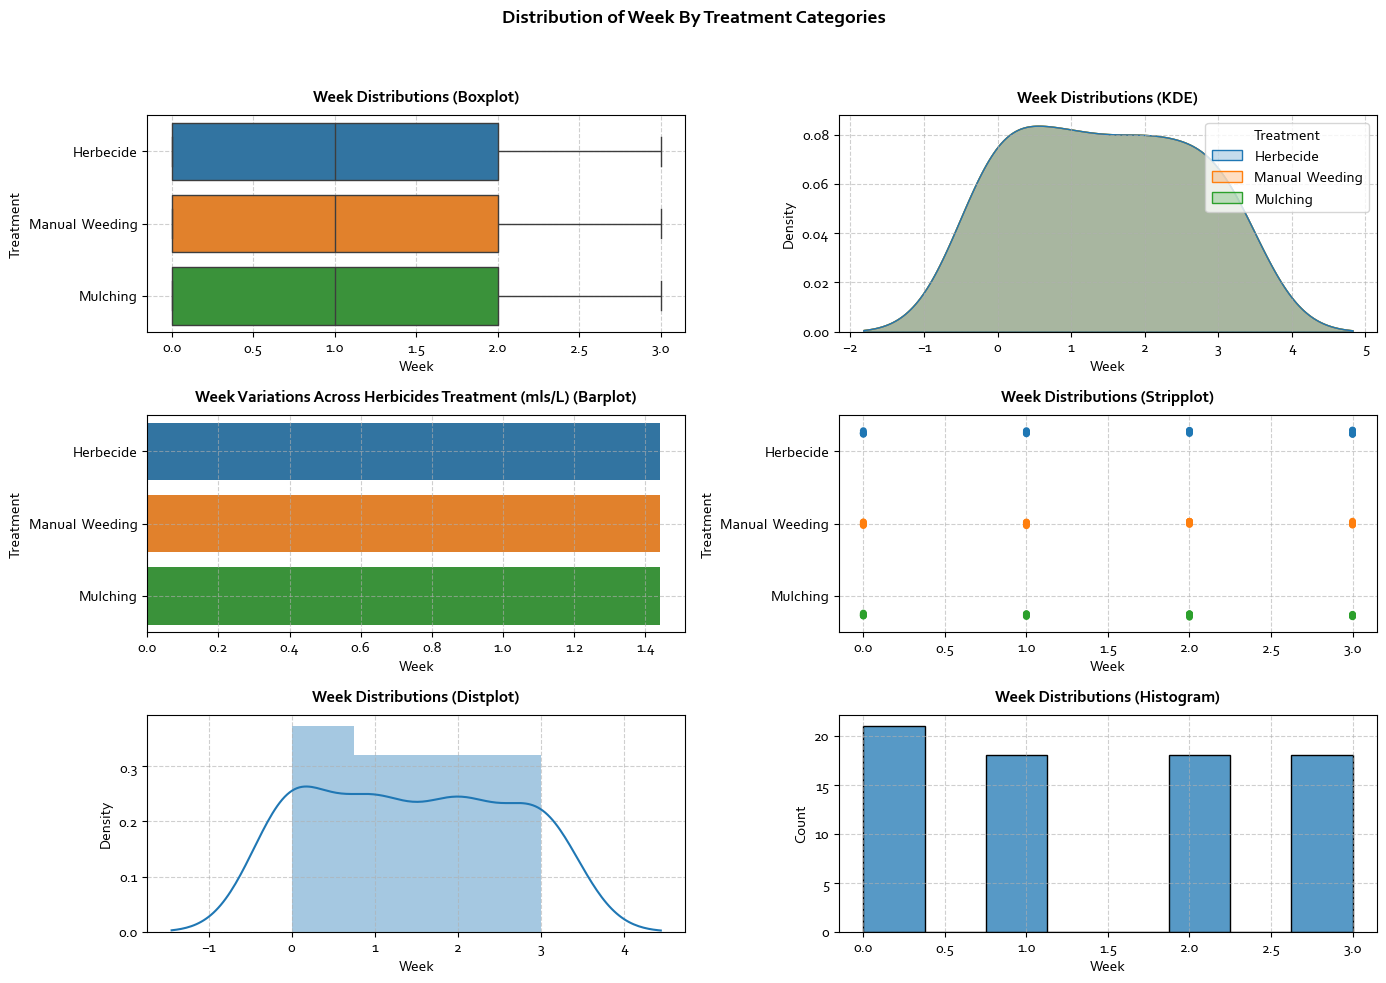

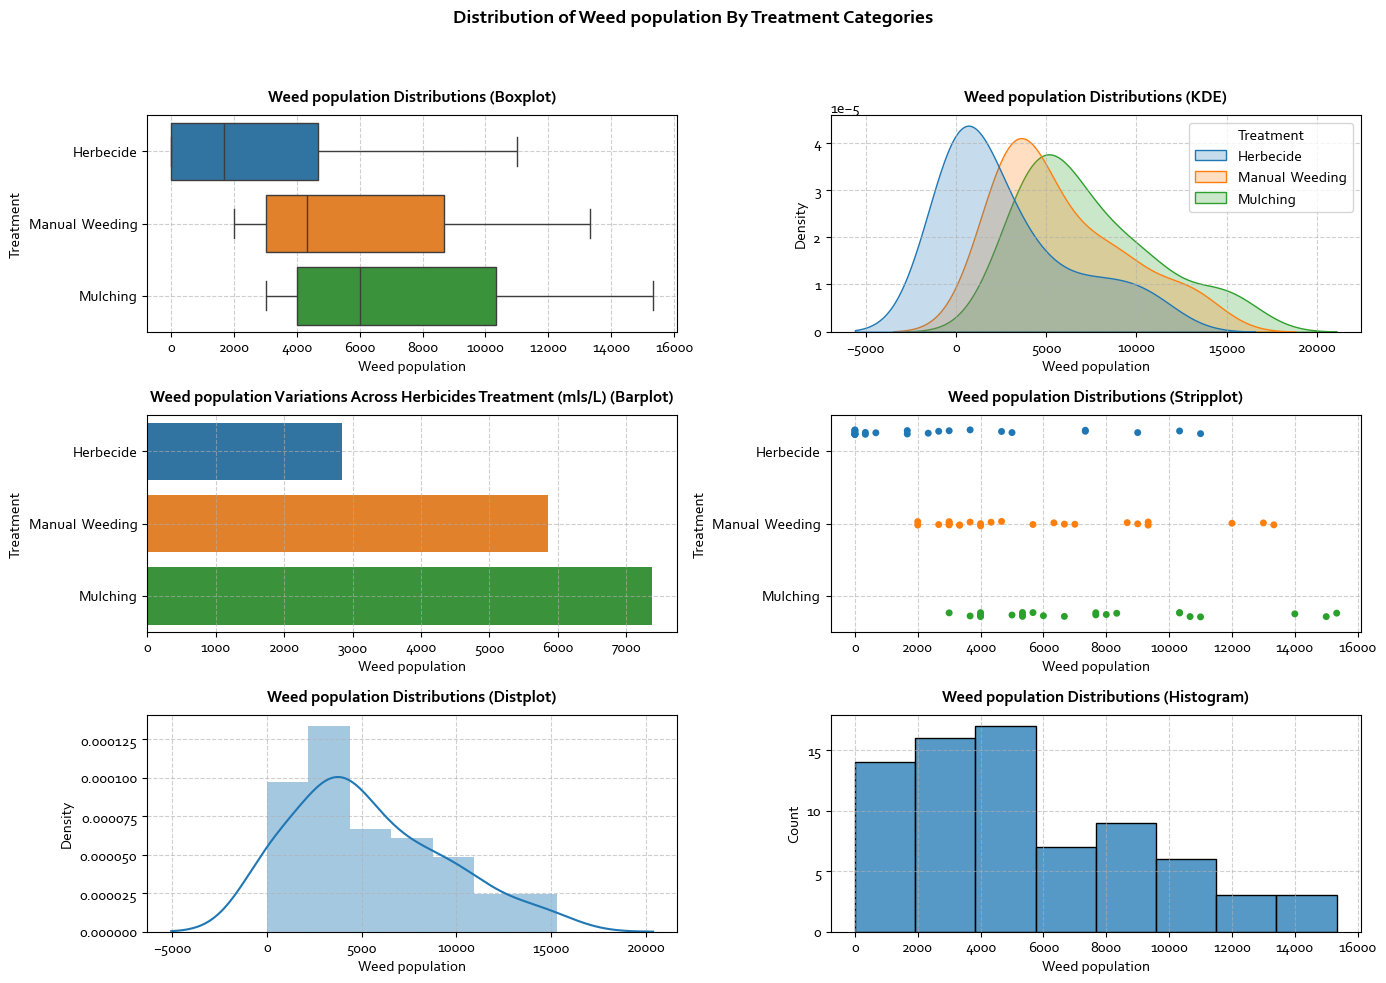

In [21]:
def set_plot_style():
    plt.rcParams.update({'font.family': 'Corbel', 'font.style': 'normal', 'font.size': 11})

def create_subplots(title):
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    fig.suptitle(title, fontsize=14, fontweight='bold')
    return fig, axes

def plot_boxplot(df, column, axes):
    sns.boxplot(data=df, x=column, y='Treatment', ax=axes[0, 0], hue='Treatment')
    axes[0, 0].set_title(f"{column} Distributions (Boxplot)", fontsize=12, fontweight='bold', pad=10)
    axes[0, 0].set_xlabel(column)
    axes[0, 0].grid(linestyle='--', alpha=0.6)

def plot_kde(df, column, axes):
    sns.kdeplot(data=df, x=column, ax=axes[0, 1], hue='Treatment', fill=True)
    axes[0, 1].set_title(f"{column} Distributions (KDE)", fontsize=12, fontweight='bold', pad=10)
    axes[0, 1].set_xlabel(column)
    axes[0, 1].grid(linestyle='--', alpha=0.6)

def plot_barplot(df, column, axes):
    sns.barplot(data=df, x=column, y='Treatment', ax=axes[1, 0], errorbar=None, hue='Treatment')
    axes[1, 0].set_title(f"{column} Variations Across Herbicides Treatment (mls/L) (Barplot)", fontsize=12, fontweight='bold', pad=10)
    axes[1, 0].set_xlabel(column)
    axes[1, 0].grid(linestyle='--', alpha=0.6)

def plot_stripplot(df, column, axes):
    sns.stripplot(data=df, x=column, y='Treatment', ax=axes[1, 1], hue='Treatment', dodge=True)
    axes[1, 1].set_title(f"{column} Distributions (Stripplot)", fontsize=12, fontweight='bold', pad=10)
    axes[1, 1].set_xlabel(column)
    axes[1, 1].grid(linestyle='--', alpha=0.6)

def plot_distribution(df, column, axes):
    sns.distplot(df[column], ax=axes[2, 0], kde=True)
    axes[2, 0].set_title(f"{column} Distributions (Distplot)", fontsize=12, fontweight='bold', pad=10)
    axes[2, 0].set_xlabel(column)
    axes[2, 0].grid(linestyle='--', alpha=0.6)

def plot_histoplot(df, column, axes):
    sns.histplot(data=df, x=column, ax=axes[2, 1])
    axes[2, 1].set_title(f"{column} Distributions (Histogram)", fontsize=12, fontweight='bold', pad=10)
    axes[2, 1].set_xlabel(column)
    axes[2, 1].grid(linestyle='--', alpha=0.6)

def generate_plots(df, metrics):
    set_plot_style()
    for column in metrics:
        fig, axes = create_subplots(f'Distribution of {column} By Treatment Categories')
        plot_boxplot(df, column, axes)
        plot_kde(df, column, axes)
        plot_barplot(df, column, axes)
        plot_stripplot(df, column, axes)
        plot_distribution(df, column, axes)
        plot_histoplot(df, column, axes)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


Metrics = df.select_dtypes(include=np.number).columns.tolist()
generate_plots(df, Metrics)

<h1 style='font-size: 20px; color: Green; font-family: Candara; font-weight: 600'>5.0: Correllation Analysis</h1>

<h3 style='font-size: 18px; color: Blue; font-family: Candara; font-weight: 600'>5.1: Correlation Coefficients </h3>

In [22]:
def compute_correlation_matrix(df, method="pearson", visualize=True):
    if method not in ['pearson', 'spearman', 'kendall']:
        raise ValueError("Invalid method. Choose from 'pearson', 'spearman', or 'kendall'.")
    
    numeric_df = df.select_dtypes(include=['number'])
    corr_matrix = numeric_df.corr(method=method)
    
    return corr_matrix


correlation_matrix = compute_correlation_matrix(df, method="pearson")
correlation_matrix

,Week,Weed population
Week,1.00,-0.52
Weed population,-0.52,1.00


<h3 style='font-size: 18px; color: orange; font-family: Candara; font-weight: 600'>5.2: Correlation Coefficients Heatmap </h3>

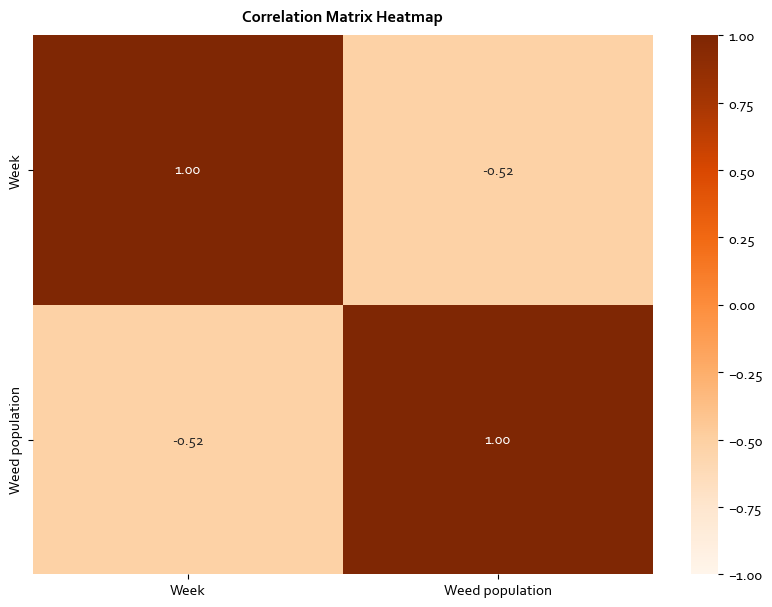

In [23]:
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='Oranges', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap', fontsize=12, fontweight='bold', pad=10)
plt.grid(False)
plt.show()

<h3 style='font-size: 18px; color: blue; font-family: candara; font-weight: 600'>5.3: Pearson’s</h3>

**Pearson’s r**: This measures the strength and direction of the linear relationship between two continuous variables. Values range from -1 to 1, with 0 indicating no relationship, 1 indicating a perfect positive relationship, and -1 indicating a perfect negative relationship.

In [24]:
from scipy.stats import pearsonr
def compute_pearson_r(df):
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    results = []

    for i, col1 in enumerate(numerical_columns):
        for col2 in numerical_columns[i+1:]:
            r_value, p_value = pearsonr(df[col1], df[col2])
            direction = ("Positive" if r_value > 0 else 
                         "Negative" if r_value < 0 else "No correlation")
            strength = ("Strong" if abs(r_value) >= 0.7 else 
                        "Moderate" if abs(r_value) >= 0.3 else "Weak")

            results.append({
                'Variable 1': col1, 'Variable 2': col2,
                'Pearson\'s r': r_value, 'P-value': p_value,
                'Direction': direction, 'Strength': strength
            })
    
    return pd.DataFrame(results)

pearson_results_df = compute_pearson_r(df)
pearson_results_df.head(10)

,Variable 1,Variable 2,Pearson's r,P-value,Direction,Strength
0,Week,Weed population,-0.52,NaN,Negative,Moderate


<h1 style='font-size: 20px; color: crimson; font-family: Candara; font-weight: 600'>6.0: Statistical Testing (Statistical Significance)</h1>

<h3 style='font-size: 19px; color: blue; font-family: Candara; font-weight: 600'>6.1: Normal Distribution (Normality Test) (Shapiro Wilk Test)</h3>

In statistical analysis, verifying whether the data follows a normal distribution is crucial before applying certain ANOVA tests. The **Normality Test** is used to assess whether a dataset aligns with a normal distribution, which is a fundamental assumption for many parametric statistical tests. Ensuring normality helps maintain the validity of these tests, as deviations from normality can affect the accuracy of statistical inferences and conclusions.

<h4 style='font-size: 19px; color: blue; font-family: Candara; font-weight: 600'>6.1.1: Visual Exploration the Normality of Our Data</h4>

<h5 style='font-size: 18px; color: Crimson; font-family: Candara; font-weight: 600'>6.1.1.1. Distribution Plot</h5>

A distribution plot combines a histogram and a KDE plot.

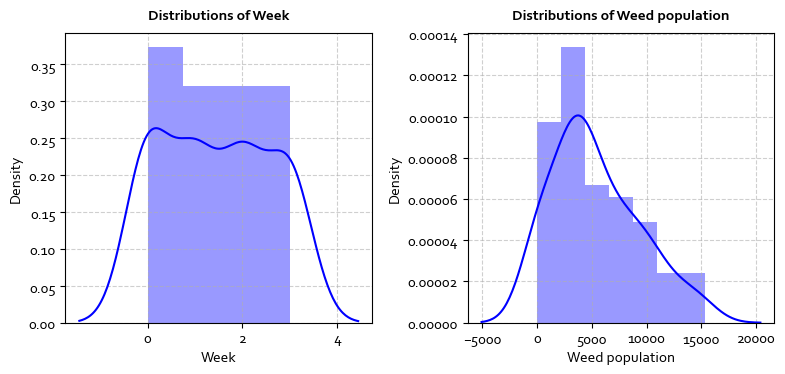

In [25]:
num_variables = len(Metrics)
rows = math.ceil(num_variables / 3)
cols = min(num_variables, 4)

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
plt.rcParams.update({'font.family': 'Dubai', 'font.style': 'normal', 'font.size': 11 })
axes = axes.flatten() if num_variables > 1 else [axes]


for idx, column in enumerate(Metrics):
    sns.distplot(df[column], ax=axes[idx], hist=True, kde=True, color='blue')   
    axes[idx].set_title(f"Distributions of {column}", fontsize=11, pad=10, fontweight='bold')
    axes[idx].set_xlabel(column, fontsize=11)
    axes[idx].grid(linestyle='--', alpha=0.6)

# Remove empty subplots if any
for idx in range(num_variables, len(axes)):
    fig.delaxes(axes[idx])
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

<h5 style='font-size: 18px; color: Crimson; font-family: Candara; font-weight: 600'>6.1.1.2. QQ Plot (Quantile-Quantile Plot)</h5>

A QQ plot compares the distribution of your data to a theoretical distribution (e.g., normal distribution).

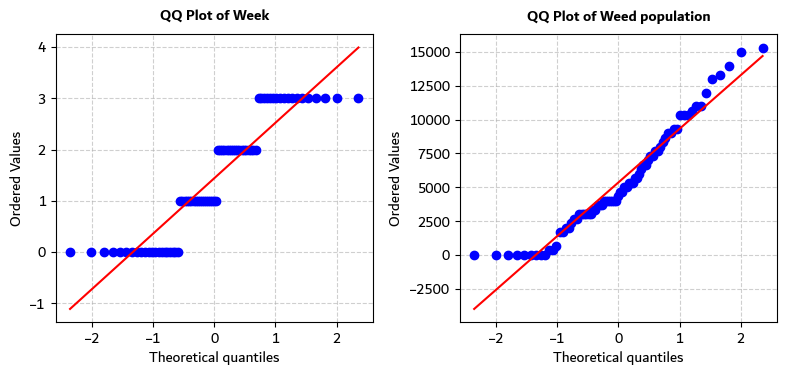

In [26]:
num_variables = len(Metrics)
rows = math.ceil(num_variables / 3)
cols = min(num_variables, 4)

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
plt.rcParams.update({'font.family': 'Dubai', 'font.style': 'normal', 'font.size': 11 })
axes = axes.flatten() if num_variables > 1 else [axes]


for idx, column in enumerate(Metrics):
    stats.probplot(df[column], dist="norm", plot=axes[idx])   
    axes[idx].set_title(f"QQ Plot of {column}", fontsize=11, pad=10, fontweight='bold')
    axes[idx].grid(linestyle='--', alpha=0.6)

# Remove empty subplots if any
for idx in range(num_variables, len(axes)):
    fig.delaxes(axes[idx])
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

<h4 style='font-size: 17px; color: Green; font-family: Candara; font-weight: 600'>6.1.2. Shapiro Wilk Test</h4>

In this analysis, we will use the **Shapiro-Wilk test** to assess whether our data follows a normal distribution. The Shapiro-Wilk test is a widely used statistical test for normality, particularly effective for small to moderately sized datasets. It evaluates how well the sample data aligns with a theoretical normal distribution by comparing the observed data to an ideal normal distribution.  The test produces a **W statistic** and a **p-value**, If the **p-value** is **greater than 0.05**, we fail to reject the null hypothesis, indicating that the data does not significantly deviate from normality and vice versa.  

Checking normality is essential because many statistical tests, including **ANOVA**, assume that the data is normally distributed. If the normality assumption is violated, we may need to consider **data transformations** (such as logarithmic or square root transformations) or use **non-parametric alternatives** like the **Kruskal-Wallis test**.

In [27]:
from scipy.stats import shapiro

def ShapirowilkTest(df):
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numerical_cols) == 0:
        raise ValueError("No numerical columns found in the DataFrame.")
    
    results = []
    for col in numerical_cols:
        stat, p_value = shapiro(df[col])
        results.append({
            'Variable': col,
            'Statistic': stat,
            'P-Value': p_value,
            'Normality': 'Normally Distributed' if p_value > 0.05 else 'Not Normally Distributed'
        })
    
    results_df = pd.DataFrame(results)
    
    results_styled = results_df.style.format({'Statistic': '{:.4f}', 'P-Value': '{:.3f}'})
    return results_df, results_styled

shapiro_results, shapiro_results_styled = ShapirowilkTest(df)
display(shapiro_results_styled)

,Variable,Statistic,P-Value,Normality
0,Week,0.8502,0.000,Not Normally Distributed
1,Weed population,0.9425,0.002,Not Normally Distributed


<h4 style='font-size: 18px; color: Green; font-family: Candara; font-weight: 600'>6.1.3: Central Limit Theorem (CLT)</h4>

In cases where our data points do not follow a normal distribution, but we have a sufficiently large sample size, we can rely on the **Central Limit Theorem (CLT)**. The CLT states that, regardless of the original distribution of the population, the sampling distribution of the sample mean will approximate a normal distribution as the sample size increases. This is true as long as the samples are **independent** and **identically distributed** (i.i.d.). The CLT is a cornerstone of inferential statistics, as it allows us to use normal distribution-based methods, such as hypothesis testing and confidence intervals, even when the original data is not normally distributed.  

<h4 style='font-size: 18px; color: Green; font-family: Candara; font-weight: 600'>6.1.4: Shapiro-Wilk Test and CLT Integration</h4>

To integrate the **Central Limit Theorem** with the **Shapiro-Wilk normality test**, we take an alternative approach when the raw data does not follow a normal distribution. Instead of testing the normality of the original dataset, we will generate multiple **sample means** through **bootstrapping**—a method of random sampling with replacement. This process involves creating **1000 sample means** for each numerical column, ensuring that the sample size for each bootstrap sample is at least **30** (a threshold often used to satisfy the conditions of the CLT).  

Once we have the bootstrap sample means, we apply the **Shapiro-Wilk test** to assess the normality of the distribution of these sample means, rather than the raw data itself. If the sample means are normally distributed, we can infer that the population mean is also normally distributed, even if the original data is skewed or not normally distributed. This approach effectively allows us to proceed with parametric tests, such as **ANOVA** or **t-tests**, despite the original data's non-normality, as long as the sample size is sufficiently large and the CLT conditions are met.

In [28]:
def ShapirowilkTest_CLT(df, num_samples=1000, sample_size=30):
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numerical_cols) == 0:
        raise ValueError("No numerical columns found in the DataFrame.")
    
    results = []
    for col in numerical_cols:
        sample_means = []

        for _ in range(num_samples):
            sample = df[col].dropna().sample(n=sample_size, replace=True)
            sample_means.append(sample.mean())

        stat, p_value = shapiro(sample_means)

        results.append({
            'Variable': col,
            'Statistic': stat,
            'P-Value': p_value,
            'Normality': 'Normally Distributed' if p_value > 0.05 else 'Not Normally Distributed'
        })
    
    results_df = pd.DataFrame(results)
    
    results_styled = results_df.style.format({'Statistic': '{:.4f}', 'P-Value': '{:.3f}'})
    
    return results_df, results_styled


shapiro_results_clt, shapiro_results_clt_styled = ShapirowilkTest_CLT(df)
shapiro_results_clt

,Variable,Statistic,P-Value,Normality
0,Week,1.00,0.00,Not Normally Distributed
1,Weed population,1.00,0.74,Normally Distributed


As you can see, after applying the Central Limit Theorem (CLT) through bootstrapping and generating 1000 sample means, the distribution of these sample means is approximately normal. This indicates that even though the original data did not follow a normal distribution, the sampling distribution of the mean has converged to normality. This allows us to proceed with parametric tests, as the CLT has effectively ensured that the population mean can be treated as normally distributed, making the data suitable for further statistical analysis.

<h4 style='font-size: 18px; color: Green; font-family: Candara; font-weight: 600'>6.1.5 Histogram Together With Central Limit Theorem (CLT</h4>


- To visually explore the normality of our data, we can use **histograms** alongside the **Central Limit Theorem (CLT)** to demonstrate its impact. A **histogram** provides a clear visual representation of the distribution of the data, allowing us to assess its shape and determine if it approximates a normal distribution.

- Initially, we can plot the histogram of the **original data** to observe its distribution. If the data appears skewed or deviates from normality, we can then apply the **CLT** through bootstrapping to generate multiple sample means. Once we have these sample means (typically at least 1000 samples), we plot a **second histogram** for the distribution of the sample means.

- According to the CLT, as the sample size increases and we generate more sample means, the histogram of these sample means should begin to approximate a normal distribution, even if the original data is not normally distributed. This visual representation helps us to see how the **sampling distribution of the mean** becomes normal, validating the applicability of parametric tests despite non-normality in the raw data.

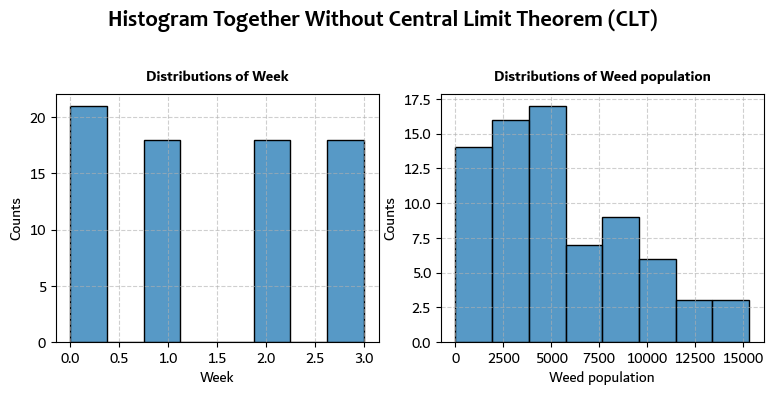

In [29]:
num_variables = len(Metrics)
rows = math.ceil(num_variables / 3)
cols = min(num_variables, 4)

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
plt.rcParams.update({'font.family': 'Candara', 'font.style': 'normal', 'font.size': 11 })
fig.suptitle('Histogram Together Without Central Limit Theorem (CLT)', fontsize=16, fontweight='bold')

axes = axes.flatten() if num_variables > 1 else [axes]


for idx, column in enumerate(Metrics):
    sns.histplot(df[column], fill=True, ax=axes[idx])   
    axes[idx].set_title(f"Distributions of {column}", fontsize=11, pad=10, fontweight='bold')
    axes[idx].set_xlabel(column, fontsize=11)
    axes[idx].set_ylabel('Counts', fontsize=11)
    axes[idx].grid(linestyle='--', alpha=0.6)

# Remove empty subplots if any
for idx in range(num_variables, len(axes)):
    fig.delaxes(axes[idx])
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

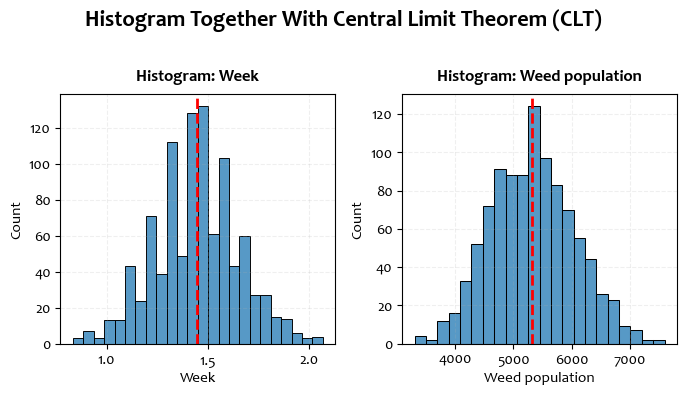

In [30]:
num_variables = len(Metrics)
rows = math.ceil(num_variables / 3)  # Number of rows in the grid
cols = min(num_variables, 4)  # Number of columns in the grid

plt.rcParams.update({'font.family': 'Candara', 'font.style': 'normal', 'font.size': 11 })
fig, axes = plt.subplots(rows, cols, figsize=(3.5*cols, 4*rows))
fig.suptitle('Histogram Together With Central Limit Theorem (CLT)', fontsize=16, fontweight='bold')
axes = axes.flatten() if num_variables > 1 else [axes]
for idx, column in enumerate(Metrics):
    sample_means = [] 
    for _ in range(1000):
        sample = df[column].dropna().sample(n=30, replace=True)  # Ensure no NaN values
        sample_means.append(sample.mean())

    sample_means = np.array(sample_means).astype(float)  
    sns.histplot(sample_means, fill=True, ax=axes[idx])
    axes[idx].axvline(np.mean(sample_means), color='red', linestyle='dashed', linewidth=2)
    axes[idx].set_title(f"Histogram: {column}", fontsize=12, pad=10, fontweight='bold')
    axes[idx].set_xlabel(column, fontsize=11)
    axes[idx].grid(linestyle='--', alpha=0.2)

for idx in range(num_variables, len(axes)):
    fig.delaxes(axes[idx])
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- After incorporating the **Central Limit Theorem (CLT)** through bootstrapping and generating multiple sample means, we can now visualize the results with histograms. Initially, the histogram of our **raw data** showed significant deviations from normality. However, after applying the CLT and creating histograms of the **sample means** (from bootstrapped samples), we observe that the distribution of these sample means is now approximately normal.

- As you can see in the updated histogram, the sampling distribution of the mean follows a much more symmetric, bell-shaped curve, which aligns with the characteristics of a normal distribution. This indicates that, despite the original data being non-normally distributed, the CLT has allowed the sample means to converge to a normal distribution. Therefore, we can confidently proceed with parametric tests, as the **sampling distribution of the mean** meets the assumption of normality, allowing us to conduct valid statistical analysis.

<h3 style='font-size: 20px; color: blue; font-family: Candara; font-weight: 600'>6.2: Homogeneity of Variance (Homoskedasticity)</h3>

- **Homogeneity of Variance (Homoskedasticity)** is an essential assumption in statistical analyses like **ANOVA**. It refers to the assumption that the variance within each group is approximately equal. When this assumption is violated, it can lead to misleading results, as unequal variances can affect the reliability of the statistical tests. One common method for testing **homogeneity of variance** is **Levene’s Test**.

- **Levene’s Test** is used to assess whether the variances of different groups are equal. The null hypothesis of Levene’s test is that the variances of the groups are equal, meaning that there is **homogeneity of variance** (homoskedasticity). If the p-value from Levene's test is greater than a chosen significance level (e.g., 0.05), we fail to reject the null hypothesis, suggesting that the variances are equal, and the assumption of homogeneity of variance holds. On the other hand, if the p-value is less than the significance level, we reject the null hypothesis and conclude that the variances are significantly different, violating the assumption of homogeneity of variance.

- This test is crucial because if the assumption of **homoskedasticity** is violated, it may suggest the need for either a data transformation, or the use of alternative statistical tests, such as **Welch's ANOVA**, which do not require the assumption of equal variances between groups.

In [31]:
from scipy.stats import levene
def LevenesTest(df, Metrics, group_col):
    results = []
    for col in Metrics:
        grouped_data = [group[col].values for _, group in df.groupby(group_col)]
        stat, p_value = levene(*grouped_data)
        results.append({
            'Variable': col, 
            'Statistic': stat, 
            'P-Value': p_value, 
            'Homogeneity': 'Homogeneous Varience' if p_value > 0.05 else 'Not Homogeneous Varience'})
    return pd.DataFrame(results)
    
levene_results = LevenesTest(df, Metrics, group_col='Treatment')
levene_results = levene_results.style.format({'Statistic': '{:.2f}', 'P-Value': '{:.4f}'})
levene_results

,Variable,Statistic,P-Value,Homogeneity
0,Week,0.00,1.0000,Homogeneous Varience
1,Weed population,0.04,0.9610,Homogeneous Varience


As you can see, all of our variables  demonstrate **homogeneity of variance** across the Treatment groups, as confirmed by the results of **Levene’s Test**. The test showed no significant differences in the variances between these groups, indicating that the assumption of **homoskedasticity** is met. With this assumption validated, we can confidently proceed with the analysis, knowing that the results will be reliable and valid.

<h3 style='font-size: 20px; color: Blue; font-family: Candara; font-weight: 600'>6.3: Analysis of Varience (One Way ANOVA)</h3>

Now, let's perform **Analysis of Variance (ANOVA)**, specifically the **One-Way ANOVA**, to assess whether there are statistically significant differences between the means of three or more independent groups. By analyzing the variance within and between groups, ANOVA helps us determine if the observed differences are due to a specific factor or just random variability. This is a crucial step in understanding how different treatments or conditions influence the outcome, providing a solid foundation for further post-hoc analysis like Tukey’s HSD to pinpoint where the differences lie.

In [32]:
def One_way_anova(data, Metrics, Factor, ):
    results = []
    for col in Metrics:
        column_name = rename(col)
        data = data.rename(columns={col: column_name})
        
        formula = f"{column_name} ~ {Factor}"
        model = ols(formula, data=data).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        
        for source, row in anova_table.iterrows():
            p_value = row["PR(>F)"]
            interpretation = "Significant difference" if p_value < 0.05 else "No significant difference"
            
            results.append({
                "Variable": col,
                "Source": source,
                "Sum Sq": row["sum_sq"],
                "df": row["df"],
                "F-Value": row["F"],
                "p-Value": p_value,
                "Interpretation": interpretation
            })
    
    # Convert the results list to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

Factor = "Treatment"
Metrics = df.select_dtypes(include=["float64", "int64"]).columns
Anova_results = One_way_anova(df, Metrics, Factor)
pd.set_option("display.float_format", "{:.4e}".format)  # Format p-value
Anova_results

,Variable,Source,Sum Sq,df,F-Value,p-Value,Interpretation
0,Week,Treatment,2.9210e-29,2.0000e+00,1.0899e-29,1.0000e+00,No significant difference
1,Week,Residual,9.6480e+01,7.2000e+01,NaN,NaN,No significant difference
2,Weed population,Treatment,2.6618e+08,2.0000e+00,1.0485e+01,1.0081e-04,Significant difference
3,Weed population,Residual,9.1389e+08,7.2000e+01,NaN,NaN,No significant difference


<h3 style='font-size: 20px; color: Blue; font-family: Dubai; font-weight: 600'>6.3.1: T-Tests for Pairwise Comparison</h3>

In [44]:
from itertools import combinations
from scipy.stats import stats, ttest_ind

dt = df[df['Treatment']== 'Herbecide']
def iterative_t_tests(dt, group_column, value_column):
    unique_groups = dt[group_column].unique()
    group_combinations = list(combinations(unique_groups, 2))
    
    results = []
    
    for group1, group2 in group_combinations:
        # Filter data for the two groups
        group1_data = dt[dt[group_column] == group1][value_column]
        group2_data = dt[dt[group_column] == group2][value_column]
        
        # Perform t-test
        t_stat, p_value = ttest_ind(group1_data, group2_data, equal_var=False)
        interpretation = "Significant difference" if p_value < 0.05 else "No significant difference"
        
        # Append results
        results.append({
            'Parameter': value_column,
            'Group 1': group1,
            'Group 2': group2,
            'T-Statistic': t_stat,
            'P-Value': p_value,
            "Interpretation": interpretation
        })
    
    # Convert results to a DataFrame
    results_dt = pd.DataFrame(results)
    return results_dt

t_test_results = iterative_t_tests(dt, group_column='Application status', value_column='Weed population')
t_test_results

,Parameter,Group 1,Group 2,T-Statistic,P-Value,Interpretation
0,Weed population,Before Application,After Application,3.760,0.001,Significant difference


<h3 style='font-size: 20px; color: Blue; font-family: Candara; font-weight: 600'>6.4: Tukey's Honest Significant Difference (THSD)</h3>


Now, let's perform **Tukey’s Honest Significant Difference (THSD) test** to determine which groups are statistically similar or different. While **ANOVA** tells us if there is a significant difference among groups, it does not specify **which** groups differ. **Tukey’s HSD** helps by comparing all possible group pairs and assigning statistical significance to their differences. This step is crucial in identifying which groups share similarities and which ones are distinct, allowing for a more detailed interpretation of the results.

In [33]:
def Turkey_results(df, group=''):
    results_data = []
    for metric in Metrics:
        turkey_results = pairwise_tukeyhsd(endog=df[metric], groups=df[group], alpha=0.05)
        results_table = turkey_results.summary()
        
        for i in range(1, len(results_table)):
            row = results_table.data[i]
            results_data.append({
                'Metric': metric,
                'Group1': row[0],
                'Group2': row[1],
                'Mean Difference': row[2],
                'P-Value': row[3],
                'Lower CI': row[4],
                'Upper CI': row[5],
                'Reject Null': row[6]
            })
        
        result_df = pd.DataFrame(results_data)
    return result_df
    
Turkeyresults = Turkey_results(df, group='Treatment')
pd.set_option("display.float_format", "{:.3f}".format)
Turkeyresults

,Metric,Group1,Group2,Mean Difference,P-Value,Lower CI,Upper CI,Reject Null
0,Week,Herbecide,Manual Weeding,0.000,1.000,-0.783,0.783,False
1,Week,Herbecide,Mulching,0.000,1.000,-0.783,0.783,False
2,Week,Manual Weeding,Mulching,0.000,1.000,-0.783,0.783,False
3,Weed population,Herbecide,Manual Weeding,3013.333,0.011,601.809,5424.858,True
4,Weed population,Herbecide,Mulching,4533.333,0.000,2121.809,6944.858,True
5,Weed population,Manual Weeding,Mulching,1520.000,0.293,-891.524,3931.524,False


<h3 style='font-size: 20px; color: Blue; font-family: Candara; font-weight: 600'>6.5: Tukey's Honest Significant Difference (THSD) Visualizations</h3>

Now, let's visualize Tukey’s Honest Significant Difference (THSD) test results to determine which groups are statistically similar or different. ANOVA indicates if there are overall significant differences, but Tukey’s HSD helps pinpoint which specific groups vary. By plotting the results, we can clearly see confidence intervals for each treatment group and easily interpret whether their means significantly differ.

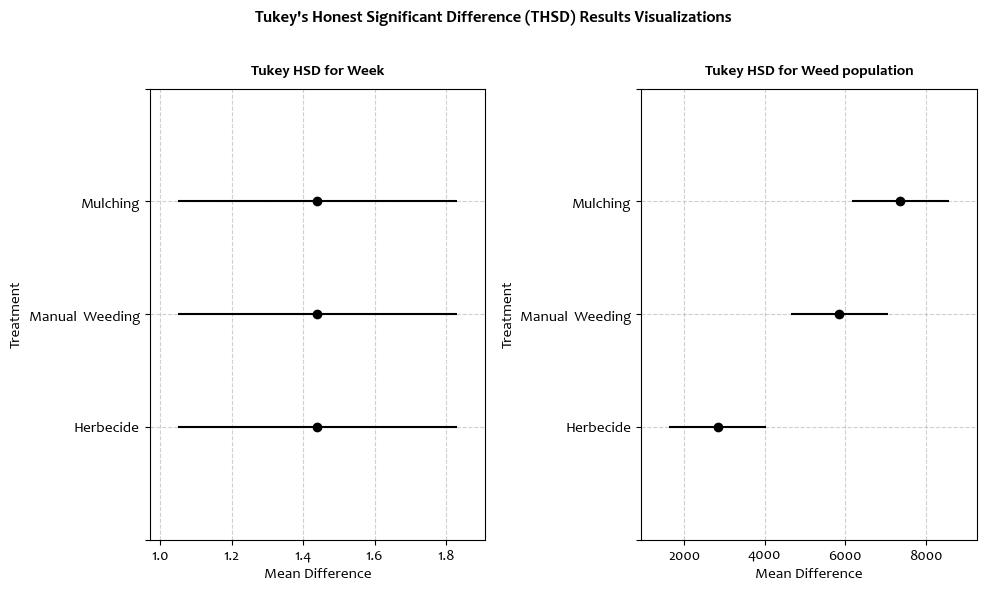

In [34]:
def plot_tukey_hsd(df, Metrics, factor_column=''):
    
    num_variables = len(Metrics)
    rows = math.ceil(num_variables / 2)
    cols = min(num_variables, 4)

    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 6*rows))
    plt.rcParams.update({'font.family': 'Candara', 'font.style': 'normal', 'font.size': 11})
    fig.suptitle("Tukey's Honest Significant Difference (THSD) Results Visualizations", fontsize=12, fontweight='bold')
    axes = axes.flatten() if num_variables > 1 else [axes]

    for idx, column in enumerate(Metrics):
        tukey_result = pairwise_tukeyhsd(df[column], df[factor_column], alpha=0.05)
        tukey_result.plot_simultaneous(ax=axes[idx])
    
        axes[idx].set_title(f"Tukey HSD for {column}", fontsize=11, pad=10, fontweight='bold')
        axes[idx].set_xlabel("Mean Difference", fontsize=11)
        axes[idx].set_ylabel(factor_column, fontsize=11)
        axes[idx].grid(linestyle="--", alpha=0.6)

    for idx in range(num_variables, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

Metrics = df.select_dtypes(include=np.number).columns.tolist()
plot_tukey_hsd(df, Metrics, factor_column='Treatment')

<h3 style='font-size: 20px; color: Blue; font-family: Candara; font-weight: 600'>6.6: Compact Letter Display (CLD)</h3>

Below is a function and accompanying scripts that will **automatically compute ANOVA and Tukey’s HSD** for all selected **metrics of interest** in the dataset. The function iterates through each metric, performs **ANOVA** to check for significant differences, then applies **Tukey’s HSD test** to determine which groups differ. Finally, it compiles all results into a **structured format**, ensuring a clear and organized presentation of statistical outcomes for easy interpretation.

In [35]:
def Compact_letters_display(df, Factor='', exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = []

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    def calculate_stats_for_column(col_name):
        # Perform OLS and ANOVA
        
        model = smf_ols(f'{col_name}~C({Factor})', data=df).fit()
        anova_results = anova_lm(model)
        
        # Extract p-value from ANOVA
        p_value = anova_results.loc[f'C({Factor})', 'PR(>F)']
        
        # Perform Tukey's test
        tukey = pairwise_tukeyhsd(df[col_name], df[Factor])
        Turkey_results = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
        group_labels = letters(Turkey_results)
        
        # Calculate statistics
        stats = df.groupby(Factor)[col_name].agg(['mean', 'sem']).round(2)
        stats['letter'] = stats.index.map(group_labels)
        stats['formatted'] = stats.apply(
            lambda x: f"{x['mean']:.2f} ± {x['sem']:.2f} {x['letter']}", axis=1)
        
        return stats['formatted'], p_value
    
    # Process each numerical column
    results = {}
    p_values = {}
    for col in numeric_cols:
        results[col], p_values[col] = calculate_stats_for_column(col)
    
    # Create the main results DataFrame
    results_df = pd.DataFrame(results)
    results_df.index.name = Factor
    
    # Add p-values row
    p_values_formatted = {col: f"{p:.4f}" + ('***' if p <= 0.001 else '**' if p <= 0.01 else '*' if p <= 0.05 else 'ns') 
                         for col, p in p_values.items()}
    p_value_df = pd.DataFrame([p_values_formatted], index=['p-value'])
    
    # Combine results with p-values
    final_results = pd.concat([results_df, p_value_df])
    
    return final_results

def letters(df, alpha=0.05):
    df["p-adj"] = df["p-adj"].astype(float)
    group1 = set(df.group1.tolist())
    group2 = set(df.group2.tolist())
    groupSet = group1 | group2
    groups = list(groupSet)
    letters = list(string.ascii_lowercase)[:len(groups)]
    cldgroups = letters
    cld = pd.DataFrame(list(zip(groups, letters, cldgroups)))
    cld[3] = ""
    
    for row in df.itertuples():
        if df["p-adj"][row[0]] > alpha:
            cld.loc[groups.index(df["group1"][row[0]]), 2] += cld.loc[groups.index(df["group2"][row[0]]), 1]
            cld.loc[groups.index(df["group2"][row[0]]), 2] += cld.loc[groups.index(df["group1"][row[0]]), 1]
        if df["p-adj"][row[0]] < alpha:
            cld.loc[groups.index(df["group1"][row[0]]), 3] += cld.loc[groups.index(df["group2"][row[0]]), 1]
            cld.loc[groups.index(df["group2"][row[0]]), 3] += cld.loc[groups.index(df["group1"][row[0]]), 1]
    
    cld[2] = cld[2].apply(lambda x: "".join(sorted(x)))
    cld[3] = cld[3].apply(lambda x: "".join(sorted(x)))
    cld.rename(columns={0: "groups"}, inplace=True)
    cld = cld.sort_values(cld.columns[2], key=lambda x: x.str.len())
    cld["labels"] = ""
    letters = list(string.ascii_lowercase)
    unique = []
    
    for item in cld[2]:
        for fitem in cld["labels"].unique():
            for c in range(len(fitem)):
                if not set(unique).issuperset(set(fitem[c])):
                    unique.append(fitem[c])
        g = len(unique)
        for kitem in cld[1]:
            if kitem in item:
                if cld.loc[cld[1] == kitem, "labels"].iloc[0] == "":
                    cld.loc[cld[1] == kitem, "labels"] += letters[g]
                if kitem in " ".join(cld.loc[cld["labels"] == letters[g], 3]):
                    g = len(unique) + 1
                if len(set(cld.loc[cld[1] == kitem, "labels"].iloc[0]).intersection(cld.loc[cld[2] == item, "labels"].iloc[0])) <= 0:
                    if letters[g] not in list(cld.loc[cld[1] == kitem, "labels"].iloc[0]):
                        cld.loc[cld[1] == kitem, "labels"] += letters[g]
                    if letters[g] not in list(cld.loc[cld[2] == item, "labels"].iloc[0]):
                        cld.loc[cld[2] == item, "labels"] += letters[g]
    
    cld = cld.sort_values("labels")
    cld.drop(columns=[1, 2, 3], inplace=True)
    cld = dict(zip(cld["groups"], cld["labels"]))
    return cld

In [36]:
Metrics = df.select_dtypes(include=['float64', 'int64']).columns

data.columns = data.columns.to_series().apply(rename)
Compact_Letter_Display = Compact_letters_display(data, Factor='treatment')
Compact_Letter_Display.columns = Metrics
Compact_Letter_Display.T

,Herbecide,Manual Weeding,Mulching,p-value
Week,1.44 ± 0.23 a,1.44 ± 0.23 a,1.44 ± 0.23 a,1.0000ns
Weed population,2840.00 ± 710.27 a,5853.33 ± 694.71 b,7373.33 ± 732.15 b,0.0001***


<h3 style='font-size: 20px; color: blue; font-family: Candara; font-weight: 600'>6.7: Compact Letter Display (CLD) Visualization</h3>

Now, let's **visualize the Compact Letter Display (CLD)** using a graph to make the results more intuitive and facilitate easy comparisons. While the tabular format provides a structured summary, graphical representation enhances clarity by visually displaying group differences. This visualization will plot the means of each treatment along with their assigned letters, making it easier to see which groups are statistically similar or different. By doing this, we ensure a **clear, interpretable, and data-driven** understanding of the results.

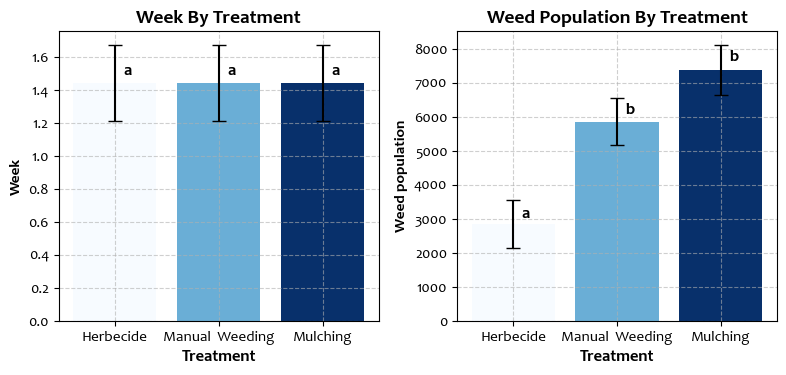

In [37]:
def compact_letter_visualizations(df, Metrics, group='Treatment', filepath=None):
    df[Metrics].columns = df[Metrics].columns.to_series().apply(rename)
    
    num_variables = len(Metrics)
    cols = min(num_variables, 4)
    rows = math.ceil(num_variables / cols)
    
    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = axes.flatten() if num_variables > 1 else [axes]
    
    for idx, col in enumerate(Metrics):
      
        # Perform Tukey's HSD test
        Turkey = pairwise_tukeyhsd(df[col], groups=df[group])
        Turkeyresults = pd.DataFrame(data=Turkey._results_table.data[1:], columns=Turkey._results_table.data[0])
        group_labels = letters(Turkeyresults)
    
        # Aggregate mean and SEM
        Aggregate_df = df.groupby(group)[col].agg(["mean", "sem"]).reset_index()
    
        # Assign the subplot to plot
        ax = axes[idx]
    
        # Plot bars
        error = np.full(len(Aggregate_df), Aggregate_df["sem"])
        colors = plt.cm.Blues(np.linspace(0, 1, len(Aggregate_df)))
        bars = ax.bar(Aggregate_df[group], Aggregate_df["mean"], yerr=error, color=colors, capsize=5)
    
        # Add compact letter annotations
        for bar, Letters in zip(bars, Aggregate_df[group]):
            height = bar.get_height()
            offset = height * 0.02  # Dynamic adjustment
            ax.annotate(group_labels[Letters],
                        xy=(bar.get_x() + bar.get_width() / 2, height + offset),
                        xytext=(9, 0),
                        textcoords="offset points",
                        ha="center", va="bottom", fontsize=12, fontweight="bold")
    
        
        # Customize the subplot
        ax.set_xticks(range(len(Aggregate_df[group])))
        ax.set_xticklabels(Aggregate_df[group], rotation=0, ha="center")
        ax.set_xlabel(group, fontsize=12, fontweight="bold")
        ax.set_ylabel(col, fontsize=11, fontweight="bold")
        ax.set_title(f"{col.title()} By {group.title()}", fontsize=14, fontweight="bold")
        ax.grid(linestyle="--", alpha=0.6)
    
    # Remove empty subplots if any
    for idx in range(num_variables, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


compact_letter_visualizations(df, Metrics, group='Treatment', filepath=None)

<h1 style='font-size: 20px; color: Green; font-family: Candara; font-weight: 600'>7.0: Effect size calculation: Quantifying Relationships and Magnitudes of an The effects</h1>

- Effect size calculation is crucial for understanding the practical significance of the results in a study. While statistical tests like t-tests and ANOVA tell us whether the results are statistically significant, effect size tells us how big or how meaningful that effect actually is. Let's break down the most common effect size measures and how we calculate them.

<h2 style='font-size: 18px; color: blue; font-family: Candara; font-weight: 600'>7.1: Partial Eta-squared (ηp²))</h2>

**Partial Eta-squared (ηp²)** is a measure of effect size that quantifies the proportion of the total variance in the dependent variable that is attributed to a particular independent variable (or factor), while controlling for the influence of other variables. This is useful in an analysis of variance (ANOVA) context, especially when multiple factors are involved.

In [38]:
def compute_partial_eta_squared(df, numerical_columns, Factors):
    results = []
    
    for column in numerical_columns:
        
        for factor in Factors:
            col = rename(column)
            df = df.rename(columns={column: col})
            
            formula = f'{col} ~ C({factor})'
            model = ols(formula, data=df).fit()
            anova_results = anova_lm(model, typ=2)
            SS_factor = anova_results['sum_sq'][f'C({factor})']
            SS_error = anova_results['sum_sq']['Residual']
            partial_eta_squared = SS_factor / (SS_factor + SS_error)
            
            results.append({
                "Variables": column,
                "Factor": factor,
                "Partial Eta-squared (ηp²)": partial_eta_squared
            })
    

    eta_squared_df = pd.DataFrame(results)
    
    def interpret_eta_squared(eta_squared):
        if eta_squared >= 0.14: return "Large effect size (≥ 14%)"
        elif eta_squared >= 0.06: return "Medium effect size (6% - 14%)"
        else: return "Small effect size (< 6%)"
    eta_squared_df['Interpretation'] = eta_squared_df['Partial Eta-squared (ηp²)'].apply(interpret_eta_squared)
    return eta_squared_df

numerical_columns = df.select_dtypes(include=["float64", "int64"]).columns
eta_squared_df = compute_partial_eta_squared(df, numerical_columns, Factors=['Treatment'])
eta_squared_df

,Variables,Factor,Partial Eta-squared (ηp²),Interpretation
0,Week,Treatment,0.000,Small effect size (< 6%)
1,Weed population,Treatment,0.226,Large effect size (≥ 14%)


<h2 style='font-size: 18px; color: Blue; font-family: Candara; font-weight: 600'>7.2. Eta-squared (η²)</h2>

**Eta-squared (η²)** is a measure of effect size used in the context of **ANOVA** to quantify the proportion of the total variance in the dependent variable that is attributable to a specific independent variable (or factor). In other words, it tells you how much of the variance in the dependent variable can be explained by the independent variable or factor in the model. Its Often used in ANOVA, eta-squared measures the proportion of variance in the dependent variable that is explained by the independent variable(s). It is interpreted as the percentage of variability explained by the factors in the model, with values ranging from 0 to 1.

In [39]:
def calculate_eta_squared(aov_table):
    ss_between = aov_table["sum_sq"].iloc[0]
    ss_total = aov_table["sum_sq"].sum()
    return ss_between / ss_total

def perform_anova_and_calculate_eta(df, metrics, independent_var):
    results = []
    for metric in metrics:
        safe_column_name = rename(metric)
        data = df.rename(columns={metric: safe_column_name})
        model = ols(f'{safe_column_name} ~ C({independent_var})', data=data).fit()
        aov_table = sm.stats.anova_lm(model, typ=2)
        eta_sq = calculate_eta_squared(aov_table)
        
        aov_table["Eta-squared (η²)"] = np.nan
        aov_table.loc[f'C({independent_var})', "Eta-squared (η²)"] = eta_sq
        
        anova_df = aov_table.reset_index().rename(columns={"index": "Source"})
        anova_df.insert(0, "Metric", metric)
        results.append(anova_df)
    
    return pd.concat(results, ignore_index=True)


Metrics = df.select_dtypes(include=np.number).columns.tolist()
Eta_squared_df = perform_anova_and_calculate_eta(df, Metrics, 'Treatment')
Eta_squared_df

,Metric,Source,sum_sq,df,F,PR(>F),Eta-squared (η²)
0,Week,C(Treatment),0.000,2.000,0.000,1.000,0.000
1,Week,Residual,96.480,72.000,NaN,NaN,NaN
2,Weed population,C(Treatment),266180740.741,2.000,10.485,0.000,0.226
3,Weed population,Residual,913893333.333,72.000,NaN,NaN,NaN


<h2 style='font-size: 18px; color: blue; font-family: Candara; font-weight: 600'>7.3. Cohen's d</h2>

This is used to measure the difference between two group means in terms of standard deviations. It is often used in t-tests or comparing two independent samples. A small Cohen's d (around 0.2), medium (around 0.5), and large (around 0.8) indicate small, medium, and large effects, respectively.

In [40]:
def cohens_d(group1, group2):
    mean1 = np.mean(group1)
    mean2 = np.mean(group2)
    std1 = np.std(group1, ddof=1)
    std2 = np.std(group2, ddof=1)
    pooled_std = np.sqrt(((std1 ** 2) + (std2 ** 2)) / 2)
    return (mean1 - mean2) / pooled_std

def interpret_cohens_d(d_value):
    if abs(d_value) < 0.2:
        interpretation = "Small effect size"
    elif 0.2 <= abs(d_value) < 0.5:
        interpretation = "Medium effect size"
    elif 0.5 <= abs(d_value) < 0.8:
        interpretation = "Large effect size"
    else:
        interpretation = "Very large effect size"
    return interpretation

def calculate_effect_sizes(df, group_column, numerical_columns):
    effect_size_results = []

    for column in numerical_columns:
        group_values = df[group_column].unique()
        for i in range(len(group_values)):
            for j in range(i + 1, len(group_values)):
                group1 = df[df[group_column] == group_values[i]][column]
                group2 = df[df[group_column] == group_values[j]][column]
                
                d_value = cohens_d(group1, group2)
                interpretation = interpret_cohens_d(d_value)
                
                effect_size_results.append({
                    'Column': column,
                    'Pair': f'{group_values[i]} vs {group_values[j]}',
                    'Cohen\'s d': d_value,
                    'Interpretation': interpretation
                
                })

    effect_size_df = pd.DataFrame(effect_size_results)
    return effect_size_df

Metrics = df.select_dtypes(include=['number']).columns
effect_sizes_df2 = calculate_effect_sizes(df, group_column="Treatment", numerical_columns=Metrics)
pd.set_option('display.max_colwidth', 120)
effect_sizes_df2

,Column,Pair,Cohen's d,Interpretation
0,Week,Herbecide vs Manual Weeding,0.000,Small effect size
1,Week,Herbecide vs Mulching,0.000,Small effect size
2,Week,Manual Weeding vs Mulching,0.000,Small effect size
3,Weed population,Herbecide vs Manual Weeding,-0.858,Very large effect size
4,Weed population,Herbecide vs Mulching,-1.257,Very large effect size
5,Weed population,Manual Weeding vs Mulching,-0.426,Medium effect size


---

This analysis was performed by **Jabulente**, a passionate and dedicated data scientist with a strong commitment to using data to drive meaningful insights and solutions.

---

<h5 style='font-size: 65px; color: crimson; font-family: Amh5erzand; font-weight: 600; text-align: center'>THE END</h5>